In [1]:
import sys
import os
import shap
import numpy as np
import xarray as xr
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch
from pathlib import Path

sys.path.append(os.path.expanduser('~/Documents/Hybrid/'))
from Hybrid.neuralnet import DEFAULT_FIT
from Hybrid.dataprep import default_prep, generate_balanced_kfold, THREEFOLD_DIVISION
from Hybrid.interpretation import combine_input_output, composite_extremes, model_to_submodel, order_by_hierachical_clustering, gradient, kernel_shap

2022-03-01 16:23:03.396191: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-01 16:23:03.396219: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [53]:
focus_class = -1 # Index of the class to be scored
npreds = 2
name = 'tg-anom_JJA_45r1_31D-roll-mean_q0.5_sep12-15'
#name = 'tg-ex-q0.75-21D_ge7D_sep12-15'
prepared_data, constructor = default_prep(predictandname=name, npreds = npreds, use_jmeasure=False, focus_class = focus_class)
aliases = np.array(['trop. west pacif. sst','north sea sst','subtrop. 850 hPa T','scand. soilm. depletion'])[:npreds]
aliases = pd.Series(aliases, index = prepared_data.crossval.X_trainval.columns.to_flat_index())

fitting a new feature scaler
fitting a new time scaler
using a pre-fitted feature scaler


Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


In [54]:
# Training the model and generating predictions
model = constructor.fresh_model()
model.fit(x = prepared_data.neural.trainval_inputs, y=prepared_data.neural.trainval_output, validation_split = 0.33, **DEFAULT_FIT)
preds_test = model.predict(x = prepared_data.neural.test_inputs)
preds_trainval = model.predict(x = prepared_data.neural.trainval_inputs)

Epoch 1/200
41/41 [==============================] - 0s 3ms/step - loss: 0.7118 - accuracy: 0.5824 - brier: 0.2521 - val_loss: 0.7508 - val_accuracy: 0.5126 - val_brier: 0.2748
Epoch 2/200
41/41 [==============================] - 0s 1ms/step - loss: 0.6302 - accuracy: 0.6874 - brier: 0.2130 - val_loss: 0.6448 - val_accuracy: 0.6151 - val_brier: 0.2292
Epoch 3/200
41/41 [==============================] - 0s 996us/step - loss: 0.6042 - accuracy: 0.7100 - brier: 0.1982 - val_loss: 0.6022 - val_accuracy: 0.6672 - val_brier: 0.2092
Epoch 4/200
41/41 [==============================] - 0s 998us/step - loss: 0.5983 - accuracy: 0.7030 - brier: 0.1961 - val_loss: 0.5927 - val_accuracy: 0.6845 - val_brier: 0.2049
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5959 - accuracy: 0.7146 - brier: 0.1954 - val_loss: 0.5927 - val_accuracy: 0.6861 - val_brier: 0.2049
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5944 - accuracy: 0.7068 - brier: 0.1

In [55]:
# Gathering outputs
feature_inputs = np.concatenate([prepared_data.neural.trainval_inputs[0],prepared_data.neural.test_inputs[0]])
log_of_raw = np.concatenate([prepared_data.neural.trainval_inputs[-1],prepared_data.neural.test_inputs[-1]])
index = prepared_data.crossval.X_trainval.index.append(prepared_data.crossval.X_test.index)
outpos = combine_input_output(model = model, feature_inputs = feature_inputs, 
                              log_of_raw = log_of_raw , target_class_index = -1, 
                              feature_names = prepared_data.raw.predictors.columns.to_flat_index(), index = index)
outneg = combine_input_output(model = model, feature_inputs = feature_inputs,
                              log_of_raw = log_of_raw, target_class_index = 0, 
                              feature_names = prepared_data.raw.predictors.columns.to_flat_index(), index = index)
outpos['change'] = outpos['f_cor'] - outpos['f_raw']
outneg['change'] = outneg['f_cor'] - outneg['f_raw']
outpos['perc_change'] = (outpos['f_cor'] - outpos['f_raw']) / outpos['f_raw'] * 100
outneg['perc_change'] = (outneg['f_cor'] - outneg['f_raw']) / outneg['f_raw'] * 100

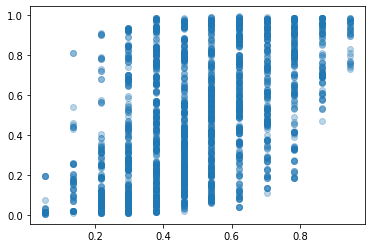

In [118]:
plt.scatter(outpos['f_raw'], outpos['f_cor'], alpha = 0.3) # The amount of change is less at the tails (already certain)

* Changes to f_raw are least present at the extremes (1,0). Inbetween a lot is possible.

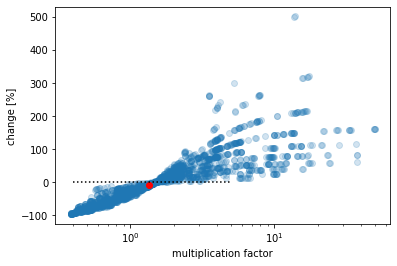

In [119]:
plt.scatter(outpos['multi'], outpos['perc_change'], alpha = 0.2)
plt.plot([0.4,5],[0,0], ls = ':', color = 'black')
plt.scatter(outpos['multi'].median(), outpos['perc_change'].median(), color = 'red')
plt.xscale('log')
plt.xlabel('multiplication factor')
plt.ylabel('change [%]')
plt.show()

* Especially multiplications below 1 lead to a reduction that is larger (probably because the negative class is scaled up heavily). The general pattern for this target is also an overall decrease of the positive class because it is overforecast.
* Same curve is present for the negative class (because of course there is a limit to multiplications >1.)

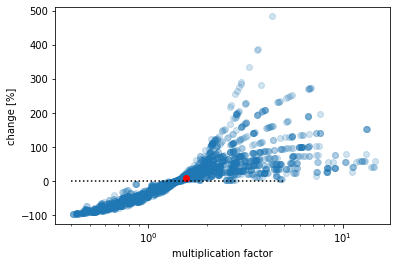

In [32]:
plt.scatter(outneg['multi'], outneg['perc_change'], alpha = 0.2)
plt.plot([0.4,5],[0,0], ls = ':', color = 'black')
plt.scatter(outneg['multi'].median(), outneg['perc_change'].median(), color = 'red')
plt.xscale('log')
plt.xlabel('multiplication factor')
plt.ylabel('change [%]')
plt.show()

In [81]:
seasonal_mean = outpos[['f_raw','multi','f_cor']].groupby(outpos.index.get_level_values('time').year).mean()
seasonal_classification,_ = generate_balanced_kfold(outpos['f_raw'])

generating test group
generating trainval groups


In [82]:
seasonal_classification.unique()

array([10, 20, 30])

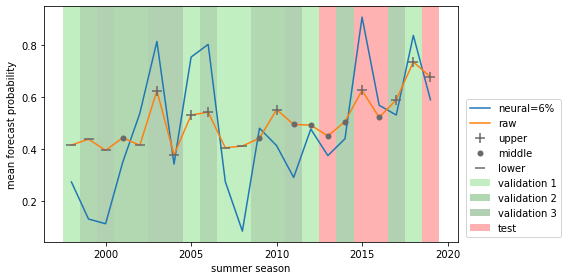

In [83]:
fig, ax1 = plt.subplots(figsize = (8,4))
ax1.plot(seasonal_mean[['f_cor','f_raw']], label = ['neural=6%','raw'])
for i, name, marker in zip(seasonal_classification.unique()[::-1],('upper','middle','lower'),('+','.','_')):
    belong_to_tercile = seasonal_mean.loc[seasonal_classification.values == i,'f_raw']
    ax1.scatter(x = belong_to_tercile.index, y = belong_to_tercile, label = name, marker = marker, s = 100, color = 'dimgrey', zorder = 20)

foldnames = pd.Series(['validation 1','validation 2','validation 3','test'], index = THREEFOLD_DIVISION.unique())
foldcolors = pd.Series(['limegreen','green','darkgreen','red'], index = foldnames.index)
for val,year in zip(THREEFOLD_DIVISION, THREEFOLD_DIVISION.index):
    ax1.axvspan(year-0.5, year+0.5, facecolor=foldcolors.loc[val], alpha = 0.3)

extra_items = [Patch(facecolor=foldcolors.loc[i],label=foldnames.loc[i], alpha = 0.3) for i in foldnames.index]

ax1.legend(handles = ax1.get_legend_handles_labels()[0] + extra_items, loc=(1.02,0.02))
ax1.set_xlabel('summer season')
ax1.set_ylabel('mean forecast probability')
plt.tight_layout()
plt.savefig(os.path.expanduser('~/Pictures/crossval_division.pdf'))

In [10]:
# Correlation matrices. Which predictors correlate best with the corrections?
# Perhaps linear correlation is not the best, as we have a non-linear method.
from scipy.stats import spearmanr

In [19]:
pearson = np.corrcoef(outpos.values.T)
spearman = spearmanr(outpos.values, axis = 0)[0]
with_change = pd.DataFrame({'pearson':pearson[-2,:],'spearman':spearman[-2,:]}, index = outpos.columns)
with_raw = pd.DataFrame({'pearson':pearson[0,:],'spearman':spearman[0,:]}, index = outpos.columns)
with_cor = pd.DataFrame({'pearson':pearson[2,:],'spearman':spearman[2,:]}, index = outpos.columns)
#plt.imshow(cormat)

In [20]:
pearson = np.corrcoef(outneg.values.T)
spearman = spearmanr(outneg.values, axis = 0)[0]
with_multi_neg = pd.DataFrame({'pearson':pearson[1,:],'spearman':spearman[1,:]}, index = outneg.columns)
with_raw_neg = pd.DataFrame({'pearson':pearson[0,:],'spearman':spearman[0,:]}, index = outneg.columns)

In [21]:
cols = ['P raw','correction','P corrected']
what = 'spearman'
tab = pd.concat([with_raw,with_change,with_cor], axis = 1, keys = cols).loc[:,(slice(None),what)]
tab = tab.iloc[3:-2,:].round(2)
tab.index = aliases.values
tab.columns = cols

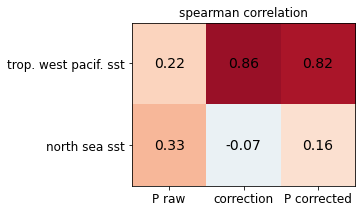

In [22]:
fig, ax = plt.subplots(figsize = (4,3), facecolor = 'white')
im = ax.imshow(tab.values, vmin = -1, vmax = 1, cmap = 'RdBu_r', aspect = 'auto')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(tab.columns)))
ax.set_xticklabels(tab.columns.to_flat_index().values, size = 12)
ax.set_yticks(np.arange(len(tab.index)))
ax.set_yticklabels(tab.index.to_flat_index().values, size = 12)
ax.set_title(f'{what} correlation')

for i, var in enumerate(tab.index):
    for j, col in enumerate(tab.columns):
        ax.text(j,i,str(tab.loc[var,col]), horizontalalignment='center',verticalalignment='center',size = 14)

# Rotate the tick labels and set their alignment.
#plt.setp(ax.get_xticklabels(), rotation=15, ha="right",rotation_mode="anchor")

* So it is interesting that there are variables with a different relation to the correction than the the raw forecast probability. This means that they are not just used for negative moderation (lowering when values are high, heightening when values are low). SSt and swvl13 are such examples.
* It can also be concluded that the variables actually have weak links to the raw forecast probabilities (and presumably also to the observation).
* The fact that the first strong factor is really related to the multi and less (but still positive) to the raw values, might indicate that this is an underexpressed link.

In [106]:
composite_extremes(outpos,level = 0.1, columnname = 'change')

,0.1,neutral,0.9
f_raw,0.568279,0.504286,0.391181
multi,0.524298,1.684330,7.449154
f_cor,0.160116,0.497607,0.852744
"(sst_nhplus, 21, 4, spatcov)",0.207460,0.482483,0.630439
"(sst, 31, 1, mean)",0.393006,0.405590,0.288531
"(t850_nhblock, 21, 0, mean)",0.411542,0.448606,0.578089
"(swvl13_europe, 11, 0, spatcov)",0.600854,0.556822,0.400795
change,-0.408163,-0.006679,0.461563
perc_change,-73.811729,-3.441662,130.640915


* The changing scales, sometimes opposite signs make me think about the association direction in scatterplots. A factor usually associated with higher probabilities, need not be in the same way be associated to overforcasting.
* plus isn't it possible to show the bivariate plot (combination of empirical factors leading to higher) for raw probabilities, and to show the same for with heightened corrected probabilities?

Text(0.5, 1.0, 'color = change')

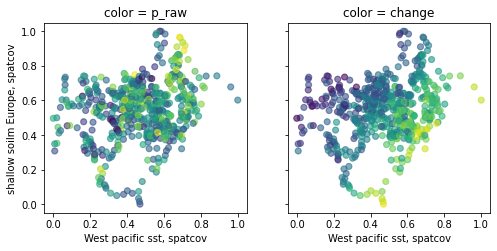

In [125]:
fig,axes = plt.subplots(ncols=2, squeeze = False, sharey = True, figsize = (8,3.5))
axes[0,0].scatter(x = outpos[('sst_nhplus', 21, 4, 'spatcov')], y = outpos[('swvl13_europe', 11, 0, 'spatcov')], alpha = 0.2, c = outpos[('f_raw')])
axes[0,1].scatter(outpos[('sst_nhplus', 21, 4, 'spatcov')],outpos[('swvl13_europe', 11, 0, 'spatcov')], alpha = 0.2, c = outpos[('change')])

axes[0,0].set_ylabel('shallow soilm Europe, spatcov')
axes[0,0].set_xlabel('West pacific sst, spatcov')
axes[0,1].set_xlabel('West pacific sst, spatcov')

axes[0,0].set_title('color = p_raw')
axes[0,1].set_title('color = change')

Setting the sst-color-code in the last plot to the change, because in itself it has a positive correlation to the raw probability (warm europe = warm north sea), this could mask the negative relation it has to the change in probability (high corrections happen when its cold). 

### Explanation of situations.
I.e. a grouping of the XAI explanations.

Full model 

In [23]:
inpgrad_full = gradient(model=model, feature_inputs = feature_inputs, additional_inputs = log_of_raw, times_input = True)
inpgrad_full = pd.DataFrame(inpgrad_full, index = index, columns = prepared_data.crossval.X_trainval.columns)
inpgrad_full = order_by_hierachical_clustering(inpgrad_full)

This exists of explanations of the final outcome. So probably we get relation to the heat in general too, which might explain big corrections at very neutral explanation values. Perhaps submodel input times gradient is more informative.

In [56]:
submodel = model_to_submodel(model, exp_of_log_of_multiplier=True)

inpgrad_sub = gradient(model=submodel, feature_inputs = feature_inputs, times_input = True)
inpgrad_sub = pd.DataFrame(inpgrad_sub, index = index, columns = prepared_data.crossval.X_trainval.columns)
inpgrad_sub = order_by_hierachical_clustering(inpgrad_sub)
inpgrad_sub.columns = aliases

exp_values, shap_sub = kernel_shap(model=submodel, feature_inputs = feature_inputs, to_explain = slice(None), target_class = 1, shapkwargs = {'silent':True})
shap_sub = pd.DataFrame(shap_sub, index = index, columns = prepared_data.crossval.X_trainval.columns)
shap_sub = order_by_hierachical_clustering(shap_sub)
shap_sub.columns = aliases

more than 300 samples detected, summarizing background dataset with shap.kmeans


In [57]:
inp = pd.DataFrame(feature_inputs, index = index, columns = prepared_data.crossval.X_trainval.columns)
inp.columns = aliases

In [58]:
# Saving for the composites.
std = False # Whether the scaling was standardization or min-max (latter = default, controlled in source code Hybrid.dataprep.scale_other_features)
savename = f'/nobackup/users/straaten/interpretation/{name}_{npreds}preds_{"std_" if std else ""}'
#inpgrad_sub.to_hdf(f'{savename}inpgrad_sub.h5', key = 'explanation', mode = 'w')
#shap_sub.to_hdf(f'{savename}shap_sub.h5', key = 'explanation', mode = 'w')
#outpos.to_hdf(f'{savename}outpos.h5', key = 'values', mode = 'w')
#inp.to_hdf(f'{savename}inp.h5', key = 'values', mode = 'w')


your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->axis0] [items->None]


your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_items] [items->None]



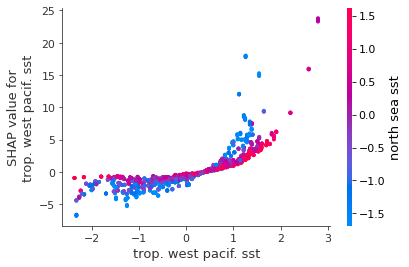

In [38]:
order = shap_sub.index
fig, ax = plt.subplots()
#ax.set_ylim(-2,10)
shap.dependence_plot(ind = 'trop. west pacif. sst', 
                     shap_values = shap_sub.reindex(order).values, features = inp.reindex(order).values, feature_names = aliases,
                    interaction_index='north sea sst', ax = ax)

#shap.dependence_plot(ind = 'trop. west pacif. sst', 
#                     shap_values = shap_sub.values, features = inp.reindex(order).values, feature_names = aliases,
#                    interaction_index='subtrop. 850 hPa T')
#plt.show()
#shap.dependence_plot(ind = 'trop. west pacif. sst', 
#                     shap_values = shap_sub.values, features = inp.reindex(order).values, feature_names = aliases,
#                    interaction_index='scand. soilm. depletion')

In [59]:
shap_sub.abs().mean(axis = 0)

trop. west pacif. sst    0.854915
north sea sst            0.471322
dtype: float64

In [60]:
inpgrad_sub.abs().mean(axis = 0)

trop. west pacif. sst    0.900446
north sea sst            0.453104
dtype: float32

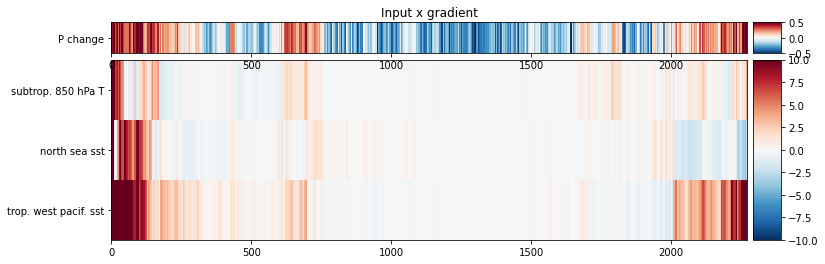

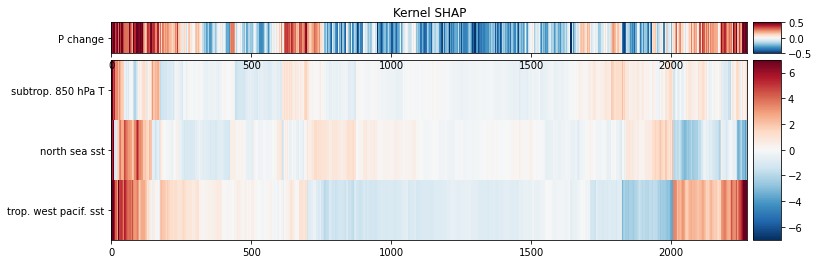

In [42]:
#order = inpgrad_sub.index
order = shap_sub.index
#order = index.sort_values()
response = 'change'
#response = 'perc_change'

fig = plt.figure(figsize=(12,4), facecolor = 'white')
gs1 = GridSpec(nrows = 6, ncols = 20, hspace=0.2)
ax_expl = fig.add_subplot(gs1[1:, :-1])
ax_cor = fig.add_subplot(gs1[:1, :-1])
ax_cbar_expl = fig.add_subplot(gs1[1:, -1:])
ax_cbar_cor = fig.add_subplot(gs1[:1, -1:])

# Input * gradient
expl = ax_expl.pcolor(inpgrad_sub.reindex(order).T.values, vmin = -10, vmax = 10, cmap = 'RdBu_r')
ax_expl.set_yticks(np.arange(0.5, len(inpgrad_sub.columns)+0.5,1))
ax_expl.set_yticklabels(inpgrad_sub.columns.to_flat_index().values)
cor = ax_cor.pcolor(outpos[[response]].reindex(order).T.values, vmin = -0.5, vmax = 0.5, cmap = 'RdBu_r')
ax_cor.set_yticks([0.5])
ax_cor.set_yticklabels([f'P {response}'])
ax_cor.set_title('Input x gradient')
fig.colorbar(expl, cax = ax_cbar_expl)
fig.colorbar(cor, cax = ax_cbar_cor)

# Only input
#expl = ax_expl.pcolor(inp.reindex(order).T.values, vmin = 0, vmax = 1, cmap = 'RdBu_r')
#ax_expl.set_yticks(np.arange(0.5, len(inpgrad_sub.columns)+0.5,1))
#ax_expl.set_yticklabels(inp.columns.to_flat_index().values)
#cor = ax_cor.pcolor(outpos[[response]].reindex(order).T.values, vmin = -0.5, vmax = 0.5, cmap = 'RdBu_r')
#ax_cor.set_yticks([0.5])
#ax_cor.set_yticklabels([f'P {response}'])
#ax_cor.set_title('Input (standardized)')
#fig.colorbar(expl, cax = ax_cbar_expl)
#fig.colorbar(cor, cax = ax_cbar_cor)

#Kernel SHAP

fig = plt.figure(figsize=(12,4), facecolor = 'white')
gs1 = GridSpec(nrows = 6, ncols = 20, hspace=0.2)
ax_expl = fig.add_subplot(gs1[1:, :-1])
ax_cor = fig.add_subplot(gs1[:1, :-1])
ax_cor.set_yticks([0.5])
ax_cor.set_yticklabels([f'P {response}'])
ax_cbar_expl = fig.add_subplot(gs1[1:, -1:])
ax_cbar_cor = fig.add_subplot(gs1[:1, -1:])

expl = ax_expl.pcolor(shap_sub.reindex(order).T.values, vmin = -7, vmax = 7, cmap = 'RdBu_r')
ax_expl.set_yticks(np.arange(0.5, len(shap_sub.columns)+0.5,1))
ax_expl.set_yticklabels(shap_sub.columns.to_flat_index().values)
cor = ax_cor.pcolor(outpos[[response]].reindex(order).T.values, vmin = -0.5, vmax = 0.5, cmap = 'RdBu_r')
ax_cor.set_title('Kernel SHAP')
fig.colorbar(expl, cax = ax_cbar_expl)
fig.colorbar(cor, cax = ax_cbar_cor)

Exploring different plotting strategy: time based sort, splitted by season.

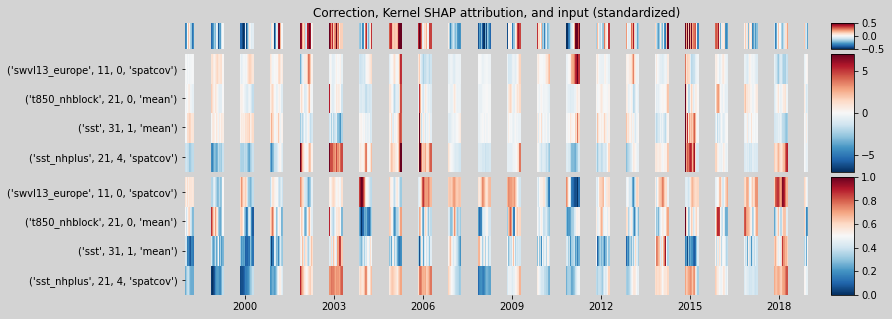

In [9]:
seps = pd.date_range(start = index.get_level_values('time').min(), end = index.get_level_values('time').max(), freq = 'A-SEP')
n_between = 150
gap_index = pd.MultiIndex.from_product([seps, np.arange(16,16+n_between)], names = index.names)
order = index.append(gap_index).sort_values()
response = 'change'
#response = 'perc_change'

facecolor = 'lightgrey'

fig = plt.figure(figsize=(12,5), facecolor = facecolor)
gs1 = GridSpec(nrows = 9, ncols = 15, hspace=0.2, wspace = 1)
ax_cor = fig.add_subplot(gs1[:1, :-1])
ax_expl = fig.add_subplot(gs1[1:5, :-1])
ax_inp = fig.add_subplot(gs1[5:, :-1])
ax_cbar_cor = fig.add_subplot(gs1[:1, -1:])
ax_cbar_expl = fig.add_subplot(gs1[1:5, -1:])
ax_cbar_inp = fig.add_subplot(gs1[5:, -1:])

cor = ax_cor.pcolor(outpos[[response]].reindex(order).T.values, vmin = -0.5, vmax = 0.5, cmap = 'RdBu_r')
ax_cor.set_title('Correction, Kernel SHAP attribution, and input (standardized)')
ax_cor.set_facecolor(facecolor)
ax_cor.xaxis.set_visible(False)
ax_cor.yaxis.set_visible(False)

expl = ax_expl.pcolor(shap_sub.reindex(order).T.values, vmin = -7, vmax = 7, cmap = 'RdBu_r')
ax_expl.set_facecolor(facecolor)
ax_expl.set_yticks(np.arange(0.5, len(inpgrad_sub.columns)+0.5,1))
ax_expl.set_yticklabels(shap_sub.columns.to_flat_index().values)
ax_expl.xaxis.set_visible(False)

inp_vals = ax_inp.pcolor(inp.reindex(order).T.values, vmin = 0, vmax = 1, cmap = 'RdBu_r')
ax_inp.set_facecolor(facecolor)
ax_inp.set_yticks(np.arange(0.5, len(inpgrad_sub.columns)+0.5,1))
ax_inp.set_yticklabels(inp.columns.to_flat_index().values)

# Color bars
fig.colorbar(cor, cax = ax_cbar_cor)
fig.colorbar(expl, cax = ax_cbar_expl)
fig.colorbar(inp_vals, cax = ax_cbar_inp)

for i in ax_cor.spines:
    ax_cor.spines[i].set_visible(False)
    ax_expl.spines[i].set_visible(False)
    ax_inp.spines[i].set_visible(False)

# Time axis
stamps = pd.date_range('2000-06-01','2019-06-01', freq = 'A-JUN')[::3]
inds = np.where(order.get_level_values('time').map(lambda t: t in stamps).values)[0]
ax_inp.set_xticks(inds)
ax_inp.set_xticklabels(stamps.year)
plt.show()

An interesting feature here is that the sst input value seems to have some slow variation in it. Though the most-important factor, this slowness does not mean a slowness of correction. Positive swvl signal in begin 2004 and 2018 seems to counteract it.

Checking what is a positive swvl13 spatcov signal in cluster 0: it is correspondence of the initial anomalies to a slightly below normal scandinavian soil moisture 